In [1]:
%matplotlib widget
import numpy as np
from FibreDesignreClasses import StackGeometry, GlassChecker

## First check the available glass

In [3]:
latestGlass = GlassChecker(0.0, 2.958, 200, 9, 158)
latestGlass.read_latest_tube_list('../Fibre Design/Tube List - June audit 2021.xlsx')
latestGlass.show_closest_capillary_tubes()
latestGlass.show_available_stack_tubes()

,Tube No,NomOD,NomID,ID/OD,Od Avg,Id Avg,id/od
847,DC21462,10.0,2.0,0.200000,10.03,1.45,NaN
272,040,15.0,3.4,0.226667,15.03,3.28,0.210875
274,041,15.0,3.4,0.226667,15.03,3.28,0.212202
275,048,15.0,3.4,0.226667,15.02,3.32,0.216180
280,054,15.0,3.4,0.226667,15.05,3.34,0.217737
269,066,15.0,3.4,0.226667,15.03,3.31,0.216324
832,003,25.5,7.6,0.298039,25.46,7.35,NaN
831,002,25.5,7.6,0.298039,25.47,7.30,NaN
833,004,25.5,7.6,0.298039,25.46,7.25,NaN
834,005,25.5,7.6,0.298039,25.47,7.39,NaN


,Tube No,NomOD,NomID,ID/OD,Od Avg,Id Avg,id/od
336,DC52499,21.0,17.0,0.809524,20.99,16.94,0.804379
341,064,22.0,19.0,0.863636,21.87,19.00,0.862745
342,065,22.0,19.0,0.863636,21.94,19.11,0.868002
343,066,22.0,19.0,0.863636,21.93,19.04,0.863967
344,067,22.0,19.0,0.863636,21.96,19.03,0.854875
347,070,22.0,19.0,0.863636,22.01,18.99,0.860254
348,071,22.0,19.0,0.863636,21.97,18.88,0.853249
352,076,22.0,19.0,0.863636,21.91,19.03,0.862147
353,077,22.0,19.0,0.863636,21.97,18.97,0.859673
354,078,22.0,19.0,0.863636,21.97,18.97,0.860909


In [4]:
latestGlass.set_capillary_sizes(20_000.0, 0.0, 22_510.0, 0.0)
latestGlass.set_stack_size(25_000.0, 19_000.)
latestGlass.calc_capillary_diameter()

Required Capillary Diameter: 1050.702400857729
Length of Core tube needed: 0.3442433395149812
Length of Capillary tube needed: 0.3091131498470947


In [5]:
latestGlass.show_jacket_options()

,Fibre Pitch at 150um (um),Fibre Diameter for Ideal Pitch (um),Number of Jacket Tubes,Jacket Od (mm),Jacket Id (mm)
0,1.681124,351.907448,1,10.0,2.0
1,2.521686,234.604965,19,10.0,3.0
2,2.941967,201.089970,20,10.0,3.5
3,3.534181,167.393813,7,8.8,3.7
4,4.202810,140.762979,2,6.0,3.0
5,5.043372,117.302483,15,10.0,6.0
6,5.603746,105.572234,5,6.0,4.0
7,5.883933,100.544985,3,10.0,7.0
8,6.724495,87.976862,5,10.0,8.0


In [6]:
core_file_path = '../COMSOL/Data/Honeycomb/realistic honeycomb coords.csv'
core_to_core_pitch = 2.958 # ensre this is the same as the pitch used in comsol

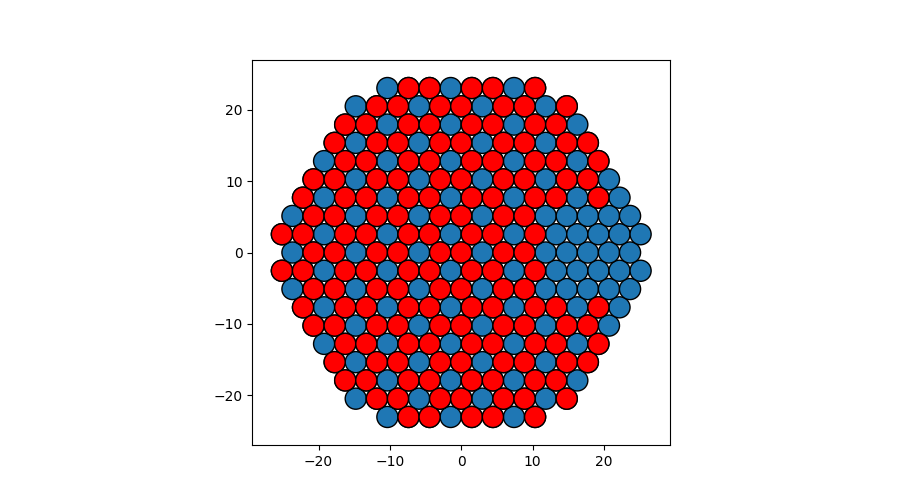

In [7]:
solidStack = StackGeometry(9, core_to_core_pitch)
solidStack.build_triangular_lattice()
solidStack.trim_lattice_to_fibre()
solidStack.add_cores_from_file(core_file_path) 
solidStack.show_fibre_design()

Capillary Diameter Required: 1050.702400857729
Required Fibre Diamter: 201.08997001742225


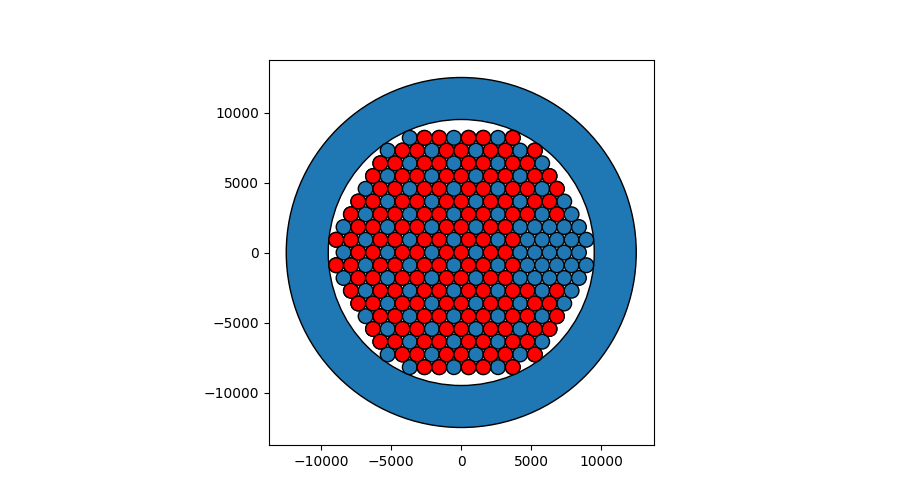

In [8]:
solidStack.choose_jacket_tube(10_000,3_500)
solidStack.choose_stack_tube(25_000, 19_000)
solidStack.scale_lattice_to_stack_size()
solidStack.show_stack_design()

In [6]:
solidStack.export_stack_design('twisted_stack_design')

In [9]:
num_of_cores = len(solidStack.coreLocations)
amount_of_doped_glass = np.pi*(1.045e-3/2)**2 * num_of_cores
num_of_rods = len(solidStack.latticePoints) - len(solidStack.coreLocations)
vol_of_glass_rod = np.pi*(22.510e-3/2)**2
print('Number of Cores: {}, Number of Rods: {}'.format(num_of_cores, num_of_rods))
print('Doped glass required: {}m^3'.format(np.round(amount_of_doped_glass,7)))
print('Fraction of short rod: {}'.format(np.round(amount_of_doped_glass/vol_of_glass_rod, 3)))

Number of Cores: 158, Number of Rods: 107
Doped glass required: 0.0001355m^3
Fraction of short rod: 0.341


## Photonic Crystal Fibre with manually selected cores

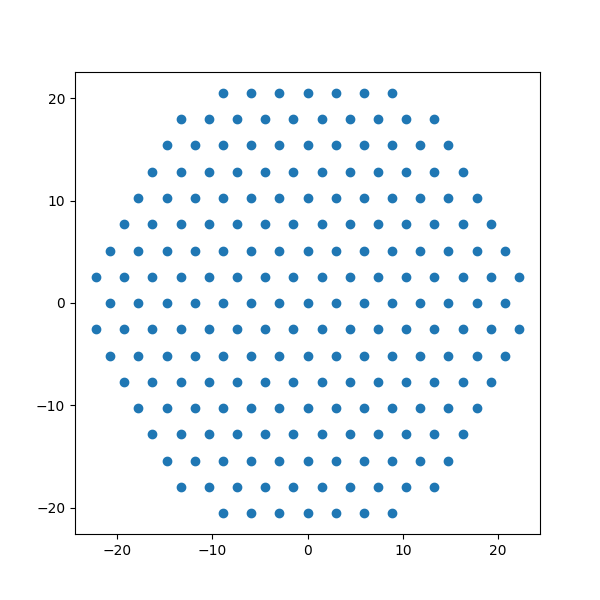

In [19]:
pcfStack = StackGeometry(8, 2.958)
pcfStack.build_triangular_lattice()
pcfStack.trim_lattice_to_fibre()
pcfStack.select_cores_with_mouse()

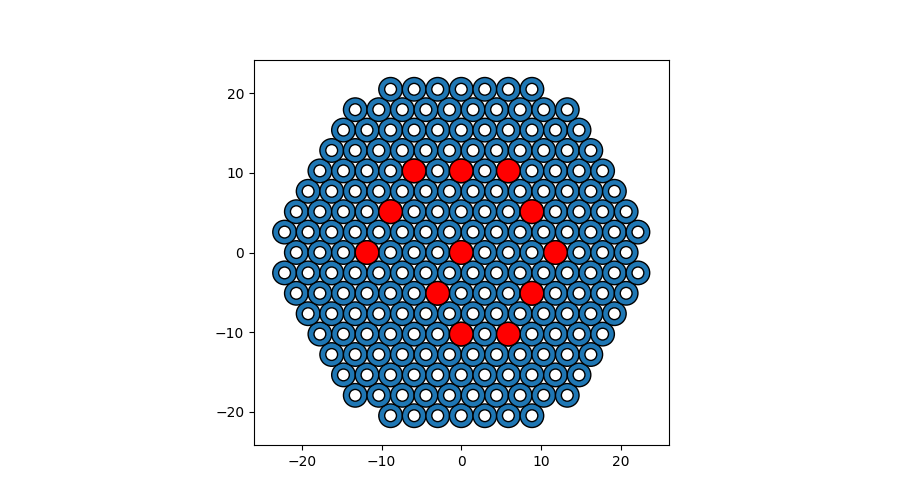

In [9]:
pcfStack.make_cores_from_selection()
pcfStack.add_pcf_airholes(0.5)
pcfStack.show_fibre_design()


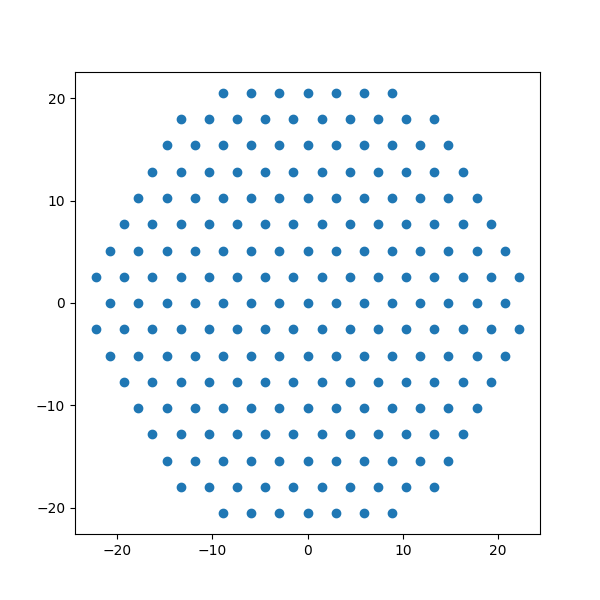

In [10]:
pcfStack.select_cores_with_mouse()

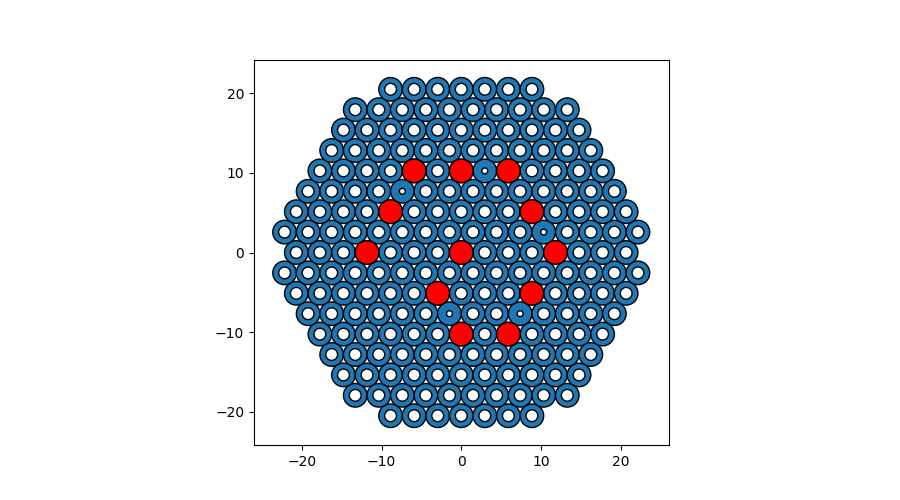

In [11]:
pcfStack.make_alternative_airhole_from_selection(0.25)
pcfStack.show_fibre_design()

Capillary Diameter Required: 1175.625
Required Fibre Diamter: 179.72203235361133


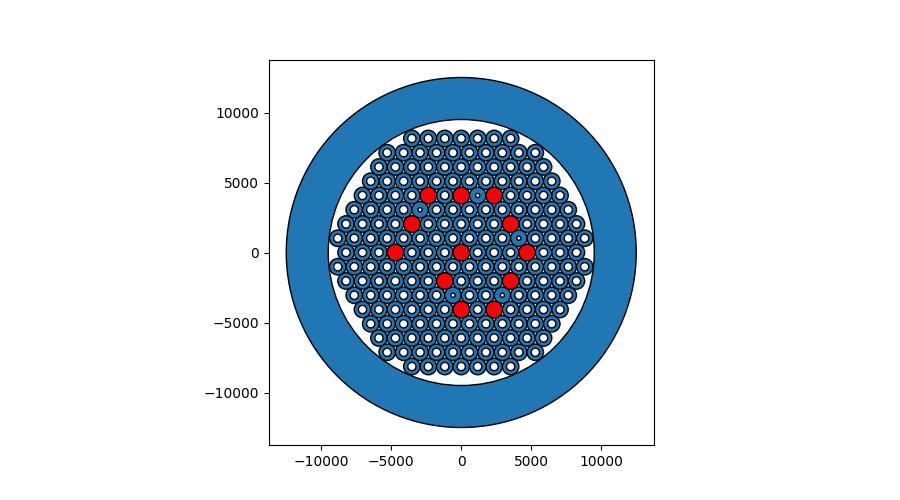

In [12]:
pcfStack.choose_jacket_tube(10_000,3_500)
pcfStack.choose_stack_tube(25_000, 19_000)
pcfStack.scale_lattice_to_stack_size()
pcfStack.show_stack_design()